In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import statsmodels.api as sm
from matplotlib.dates import DateFormatter, AutoDateLocator
from matplotlib.ticker import FuncFormatter

pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

sns.set_theme()

In [58]:
def load_data(file_path: str = '../data/trade_history.csv') -> pd.DataFrame:
    # Load the CSV into a DataFrame
    df = pd.read_csv(file_path)
    
    # Convert to datetime
    date_columns = ['Entry time', 'Exit time']
    for col in date_columns:
        df[col] = pd.to_datetime(df[col])
    
    # Convert percentage return to float
    df['Return'] = df['Return'].str.rstrip('%').astype(float) / 100

    return df

df = load_data()
df.head()

,Trade number,Instrument,Account,Strategy,Market pos.,Qty,Entry price,Exit price,Entry time,Exit time,Entry name,Exit name,Profit,Cum. net profit,Cum. cash value,Commission,MAE,MFE,ETD,Bars,HWM,Drawdown,Return,Instrument Vol,Instrument Vol Floor,Annual Vol Target,Annual Realized Vol,Strat Scalar
0,1,NQ,Backtest,TrendVol,Long,4,5020.50,5018.50,2017-01-10 02:54:00,2017-01-10 09:40:00,Trend Long,Stop loss,-$182.72,-$182.72,"$99,817.28",$22.72,$300.00,$600.00,$782.72,15,"$100,000.00",-0.18%,-0.0018,0.000819,0.002,0.2,0.166956,0.778614
1,2,NQ,Backtest,TrendVol,Long,3,5028.50,5036.25,2017-01-10 10:56:00,2017-01-10 13:51:00,Trend Long,Stop loss,$447.96,$265.24,"$100,265.24",$17.04,$165.00,"$1,110.00",$662.04,7,"$100,265.24",0.00%,0.0045,0.000775,0.002,0.2,0.178878,0.651149
2,3,NQ,Backtest,TrendVol,Long,3,5047.50,5041.50,2017-01-11 16:03:00,2017-01-11 19:14:00,Trend Long,Stop loss,-$377.04,-$111.80,"$99,888.20",$17.04,$360.00,$45.00,$422.04,5,"$100,265.24",-0.38%,-0.0038,0.000754,0.002,0.2,0.155804,0.632381
3,4,NQ,Backtest,TrendVol,Long,4,5048.75,5053.50,2017-01-13 09:34:00,2017-01-13 12:28:00,Trend Long,Stop loss,$357.28,$245.48,"$100,245.48",$22.72,$580.00,"$1,160.00",$802.72,6,"$100,265.24",-0.02%,0.0036,0.000751,0.002,0.2,0.118007,1.236208
4,5,NQ,Backtest,TrendVol,Long,4,5054.50,5048.25,2017-01-18 10:05:00,2017-01-18 10:09:00,Trend Long,Stop loss,-$522.72,-$277.24,"$99,722.76",$22.72,$500.00,$0.00,$522.72,1,"$100,265.24",-0.54%,-0.0052,0.000757,0.002,0.2,0.098349,1.859764


In [59]:
# Group daily return
daily = df.groupby(df['Entry time'].dt.date).agg({
    'Return': 'sum',
    'Entry time': 'last'
}).reset_index(drop=True)

In [60]:
# Calculate cumulative returns for TrendVol
daily['Cum_Return'] = (1 + daily['Return']).cumprod()

In [61]:
# Define start and end date range
start_date = df['Entry time'].min()
end_date = df['Entry time'].max()

# Download TQQQ data from yfinance
tqqq = yf.download('TQQQ', start=start_date, end=end_date).reset_index()

# Calculate TQQQ returns and cumulative returns
tqqq['Returns'] = tqqq['Adj Close'].pct_change()
tqqq['Cum_Returns'] = (1 + tqqq['Returns']).cumprod()

[*********************100%***********************]  1 of 1 completed


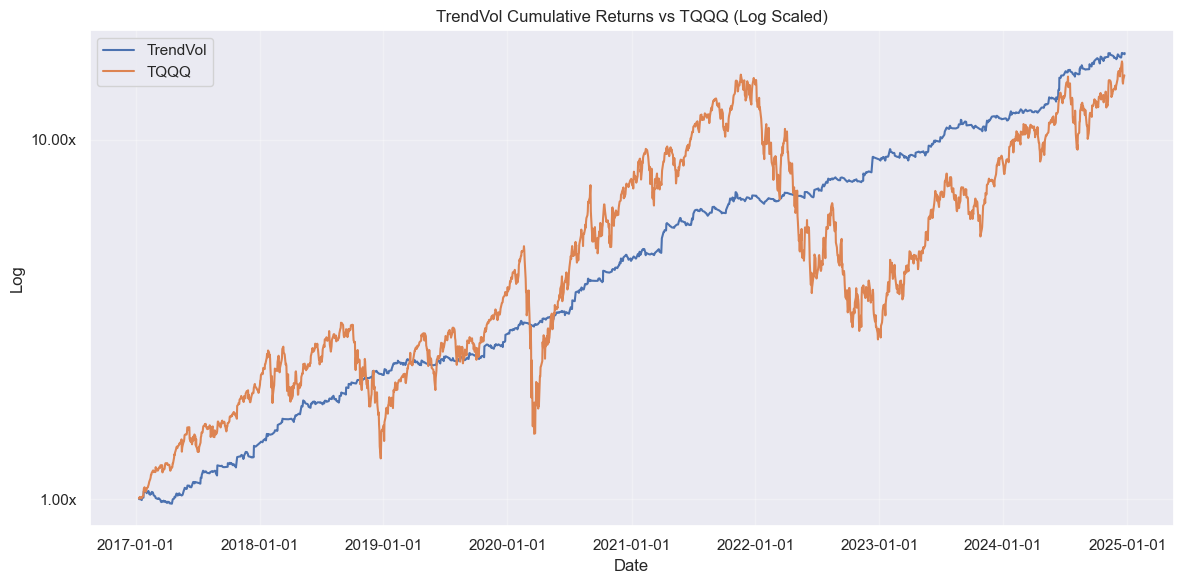

In [62]:
plt.figure(figsize=(12, 6))

ax = plt.gca()

ax.set_yscale('log')

ax.plot(daily['Entry time'], daily['Cum_Return'], label='TrendVol')
ax.plot(tqqq['Date'], tqqq['Cum_Returns'], label='TQQQ')


def return_formatter(x, pos):
    return f'{x:.2f}x'

ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(AutoDateLocator())
ax.yaxis.set_major_formatter(FuncFormatter(return_formatter))

plt.title('TrendVol Cumulative Returns vs TQQQ (Log Scaled)')
plt.xlabel('Date')
plt.ylabel('Log')
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [63]:
# Merge and clean data
merged_df = pd.merge(
    daily[['Entry time', 'Return']],
    tqqq[['Date', 'Returns']],
    left_on=pd.to_datetime(daily['Entry time']).dt.date,
    right_on=pd.to_datetime(tqqq['Date']).dt.date,
    how='inner'
).dropna()

In [64]:
X = merged_df['Returns']
X_quad = np.column_stack((X, X**2))
X_with_const = sm.add_constant(X_quad)
y = merged_df['Return']

model = sm.OLS(y, X_with_const)
results = model.fit()

print(results.summary())

print("\nKey Metrics Explanation:")
print(f"R-squared: {results.rsquared:.3f} - This indicates that {results.rsquared*100:.1f}% of the variance in strategy returns is explained by TQQQ returns and its square.")
print(f"x1 (Linear Term) p-value: {results.pvalues['x1']:.3f} - {'Significant' if results.pvalues['x1'] < 0.05 else 'Not significant'} relationship with TQQQ. A p-value < 0.05 indicates statistical significance.")
print(f"x2 (Quadratic Term) p-value: {results.pvalues['x2']:.3f} - {'Significant' if results.pvalues['x2'] < 0.05 else 'Not significant'} relationship. A p-value < 0.05 is desired to confirm non-linear effects.")
print(f"Alpha (Intercept): {results.params['const'] * 100:.2f}% - Suggests the average daily return not explained by TQQQ, indicating potential to deliver excess returns (alpha) beyond what is captured by TQQQ.")
print(f"Annualized Alpha: {results.params['const'] * 253 * 100:.2f}% - Average annualized return not explained by TQQQ.")

                            OLS Regression Results                            
Dep. Variable:                 Return   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     48.10
Date:                Thu, 09 Jan 2025   Prob (F-statistic):           1.04e-20
Time:                        12:58:59   Log-Likelihood:                 3063.5
No. Observations:                1050   AIC:                            -6121.
Df Residuals:                    1047   BIC:                            -6106.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.000      1.542      0.1

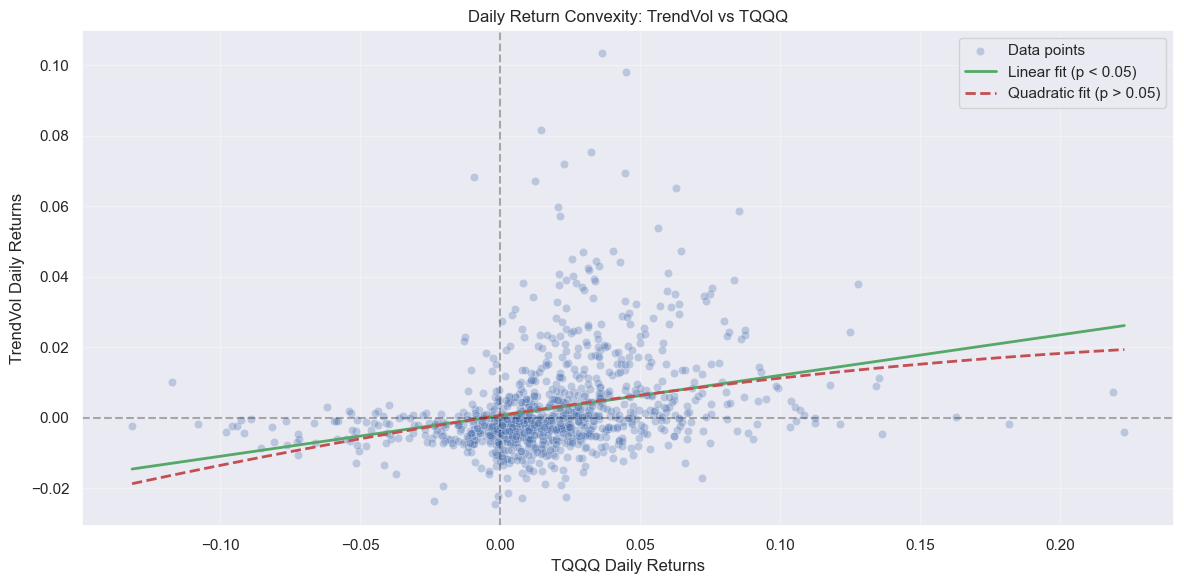

In [65]:
plt.figure(figsize=(12, 6))

sns.scatterplot(data=merged_df, x='Returns', y='Return', alpha=0.3, label='Data points')

# Prepare data for linear fit
X_linear = sm.add_constant(merged_df['Returns'])
model_linear = sm.OLS(merged_df['Return'], X_linear).fit()
x_vals = np.linspace(merged_df['Returns'].min(), merged_df['Returns'].max(), 100)
y_linear = model_linear.params['const'] + model_linear.params['Returns'] * x_vals

# Prepare data for quadratic fit
y_quad = (results.params['const'] 
          + results.params['x1'] * x_vals 
          + results.params['x2'] * x_vals**2)

# Plot linear fit
plt.plot(x_vals, y_linear, color='g', label='Linear fit (p < 0.05)', linewidth=2)

# Plot quadratic fit
plt.plot(x_vals, y_quad, color='r', linestyle='--', label='Quadratic fit (p > 0.05)', linewidth=2)

plt.axhline(0, color='black', linestyle='--', alpha=0.3)
plt.axvline(0, color='black', linestyle='--', alpha=0.3)

plt.title('Daily Return Convexity: TrendVol vs TQQQ')
plt.xlabel('TQQQ Daily Returns')
plt.ylabel('TrendVol Daily Returns')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()